In [1]:
%matplotlib inline 
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import glob
import random
import re
import time
import math
import os
import sys

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.engine.input_layer import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.objectives import categorical_crossentropy
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


In [2]:
import importlib
sys.path.append('..')
import Shared  # Shared.py holds functions common to all notebooks
importlib.reload(Shared)  # In case you make changes to the Shared.py file and don't want to restart the nb kernel 

<module 'Shared' from '/home/eduardo/Desktop/Link to dynamic-projections/Models/Shared.py'>

In [3]:
nb_name = 'fashion-VAE_784f_2048f_1024f_512f_2f_0-25drop_20ep'

In [4]:
X, info_df, n_revisions, CATEGORIES = Shared.load_drawings('../../Datasets/fashion/')
# Flatten Nx28x28 -> Nx784x1
N = len(X)
# np.reshape(X, (len(X), 1, 784))
X_flat = np.reshape(np.ravel(X), (N, -1))
len(X), len(info_df), n_revisions, CATEGORIES

(10000,
 10000,
 10,
 {0: 'ankleboot',
  1: 'bag',
  2: 'coat',
  3: 'dress',
  4: 'pullover',
  5: 'sandal',
  6: 'shirt',
  7: 'sneaker',
  8: 'trouser',
  9: 'tshirt'})

In [5]:
info_df.head()

,X_index,drawing_cat_id,drawing_cat_str,drawing_id,t
0,0,9,tshirt,687,3
1,1,0,ankleboot,596,0
2,2,2,coat,589,8
3,3,5,sandal,399,1
4,4,2,coat,12,3


In [6]:
X_flat.shape

(10000, 784)

In [7]:
(x_train, x_test) = train_test_split(X_flat, test_size=0.1, shuffle=True, random_state=0)

In [8]:
x_train.shape, x_test.shape

((9000, 784), (1000, 784))

In [9]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_lvar = args
    
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # By default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5*z_lvar)*epsilon

n = X_flat.shape[1]

# Encoder
inputs = Input(shape=(n,), name='encoder_input')
layer1 = Dense(2048, activation='relu')(inputs)
drop_1 = Dropout(0.25)(layer1)
layer2 = Dense(1024, activation='relu')(drop_1)
drop_2 = Dropout(0.25)(layer2)
layer3 = Dense(512, activation='relu')(drop_2)
drop_3 = Dropout(0.25)(layer3)
z_mean = Dense(2, name='z_mean')(drop_3)
z_lvar = Dense(2, name='z_lvar')(drop_3)
l_code = Lambda(sampling, name='l_code')([z_mean, z_lvar])

encoder = Model(inputs, [z_mean, z_lvar, l_code], name='encoder')

# Decoder
i_code = Input(shape =(2,), name='z_sampled')
layer4 = Dense(512, activation='relu')(i_code)
drop_4 = Dropout(0.25)(layer4)
layer5 = Dense(1024, activation='relu')(drop_4)
drop_5 = Dropout(0.25)(layer5)
layer6 = Dense(2048, activation='relu')(drop_5)
drop_6 = Dropout(0.25)(layer6)
output = Dense(n)(drop_6)

decoder = Model(i_code, output, name='decoder')

# VAE
va_out = decoder(encoder(inputs)[2])
vae = Model(inputs, va_out, name='vae')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
encoder.summary()
decoder.summary()
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         1607680     encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1024)         2098176     dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [11]:
# Build VAE loss function. It takes into account the variance layer outputs too.
reconstruction_loss = mse(inputs, va_out)
reconstruction_loss *= 784
kl_loss = 1 + z_lvar - K.square(z_mean) - K.exp(z_lvar)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [12]:
# Compile and summary
vae.compile(optimizer='adam', metrics=['accuracy'])

In [13]:
# Train the VAE.
h = vae.fit(x_train, epochs=20, batch_size=32, validation_data=(x_test, None))

Instructions for updating:
Use tf.cast instead.
Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 63s 7ms/step - loss: 74.4349 - val_loss: 59.5242
Epoch 2/20
9000/9000 [==============================] - 54s 6ms/step - loss: 60.7543 - val_loss: 58.6447
Epoch 3/20
9000/9000 [==============================] - 54s 6ms/step - loss: 58.9574 - val_loss: 56.9637
Epoch 4/20
9000/9000 [==============================] - 53s 6ms/step - loss: 58.1076 - val_loss: 56.1061
Epoch 5/20
9000/9000 [==============================] - 54s 6ms/step - loss: 57.5442 - val_loss: 54.9580
Epoch 6/20
9000/9000 [==============================] - 58s 6ms/step - loss: 57.1355 - val_loss: 54.8965
Epoch 7/20
9000/9000 [==============================] - 55s 6ms/step - loss: 56.6932 - val_loss: 53.8352
Epoch 8/20
9000/9000 [==============================] - 47s 5ms/step - loss: 56.6205 - val_loss: 56.1809
Epoch 9/20
9000/9000 [==============================] - 45s 5ms/

In [14]:
x_pred = vae.predict(x_test[1:2])

In [15]:
x_pred.shape

(1, 784)

In [16]:
x_pred = x_pred.reshape((28, 28))

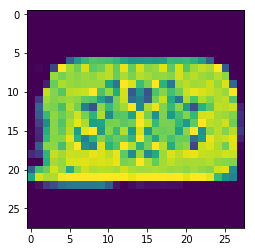

In [17]:
plt.imshow(x_test[1].reshape((28, 28)))

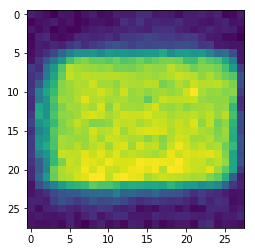

In [18]:
plt.imshow(x_pred)

In [19]:
# vae.save('../Models/{}.h5'.format(nb_name))

Text(0.5, 0.98, 'loss')

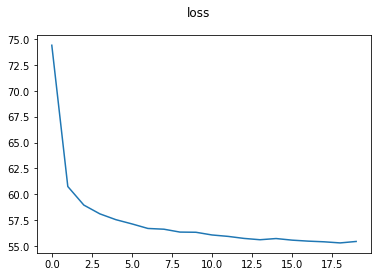

In [20]:
plt.figure()
plt.plot(vae.history.history['loss'])
plt.suptitle('loss')

In [21]:
Shared.save_drawing_vae_activations(encoder, X_flat, info_df, n_revisions, nb_name)

True